In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [9]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

num_words = 10000

def load_data(train_data, test_data, num_words=num_words):
    # [[YOUR CODE]]
    #데이터의 중복을 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    #데이터의 결측치를 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        #데이터를 토큰화 시킨다 ex) 안녕 = 1
        temp_X = tokenizer.morphs(sentence) # 토큰화
        #stopwords에 있는 불용어들이 문장에 있으면 제거 해줍니다.
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공
---
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [5]:
decoded_sentences = get_decoded_sentences(X_train, index_to_word)
print(decoded_sentences[0:5])

['더 빙 . . 진짜 짜증 나 네요 목소리', '. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나', '재 ', '이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정', '익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던   너무나 이뻐 보였 다']


In [6]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있음
word_to_index = {k:(v+1) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1]) # '<BOS>'가 출력

<BOS>


In [7]:
### 적절한 문장길이 찾기 - 최대 길이를 평균+2X표준편차 의 사이즈로 하겠습니다.
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [10]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
X_train[0]

(146182, 41)


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  32,  74, 919,   4,   4,  39, 228,  20,
        33, 748], dtype=int32)

## 4) 모델 구성 및 validation set 구성
---
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.2,shuffle=True, random_state=0)

## 5) 모델 훈련 개시, Loss, Accuracy 그래프 시각화
---

- LSTM

In [12]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 41  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(512))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim .

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 41)          410000    
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1134592   
_________________________________________________________________
dense (Dense)                (None, 8)                 4104      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,548,705
Trainable params: 1,548,705
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# earlystopping을 이용해서 과적합을 방지
from keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,callbacks=[es],
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/20
229/229 [==============================] - 20s 54ms/step - loss: 0.4682 - accuracy: 0.7760 - val_loss: 0.3594 - val_accuracy: 0.8442
Epoch 2/20
229/229 [==============================] - 12s 53ms/step - loss: 0.3294 - accuracy: 0.8602 - val_loss: 0.3477 - val_accuracy: 0.8490
Epoch 3/20
229/229 [==============================] - 12s 53ms/step - loss: 0.3029 - accuracy: 0.8726 - val_loss: 0.3413 - val_accuracy: 0.8527
Epoch 4/20
229/229 [==============================] - 12s 54ms/step - loss: 0.2786 - accuracy: 0.8842 - val_loss: 0.3414 - val_accuracy: 0.8536
Epoch 5/20
229/229 [==============================] - 13s 55ms/step - loss: 0.2560 - accuracy: 0.8940 - val_loss: 0.3500 - val_accuracy: 0.8546
Epoch 6/20
229/229 [==============================] - 13s 55ms/step - loss: 0.2341 - accuracy: 0.9038 - val_loss: 0.3725 - val_accuracy: 0.8509
Epoch 7/20
229/229 [==============================] - 13s 57ms/step - loss: 0.2153 - accuracy: 0.9133 - val_loss: 0.3675 - val_accuracy:

In [14]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


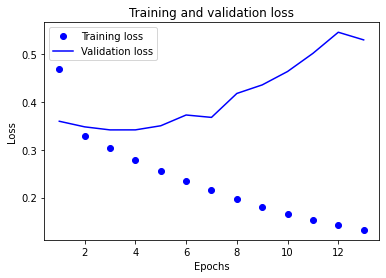

In [15]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

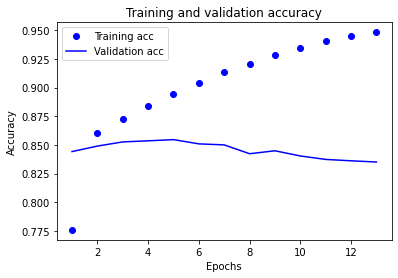

In [16]:
plt.clf()   # 그림을 초기화
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 1-D CNN

In [17]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          4608      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,callbacks=[es],
                    validation_data=(X_val, y_val),
                    verbose=1)
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/20
229/229 [==============================] - 2s 6ms/step - loss: 0.0156 - accuracy: 0.9947 - val_loss: 1.1793 - val_accuracy: 0.8198
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.0132 - accuracy: 0.9955 - val_loss: 1.2127 - val_accuracy: 0.8190
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.0120 - accuracy: 0.9959 - val_loss: 1.2580 - val_accuracy: 0.8149
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.0108 - accuracy: 0.9962 - val_loss: 1.2978 - val_accuracy: 0.8134
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.0096 - accuracy: 0.9965 - val_loss: 1.3127 - val_accuracy: 0.8166
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.0106 - accuracy: 0.9960 - val_loss: 1.3732 - val_accuracy: 0.8133
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.0135 - accuracy: 0.9950 - val_loss: 1.3675 - val_accuracy: 0.8104
Epoch 

In [24]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


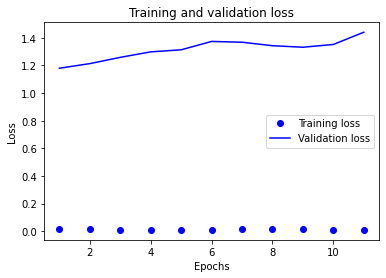

In [28]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

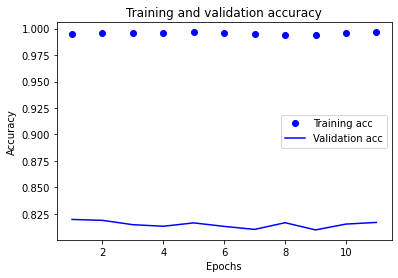

In [29]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- GlobalMaxPooling1D

In [30]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 41)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 336       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 410,345
Trainable params: 410,345
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,callbacks=[es],
                    validation_data=(X_val, y_val),
                    verbose=1)
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/20
229/229 [==============================] - 2s 4ms/step - loss: 0.5764 - accuracy: 0.7294 - val_loss: 0.4232 - val_accuracy: 0.8249
Epoch 2/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3605 - accuracy: 0.8491 - val_loss: 0.3589 - val_accuracy: 0.8428
Epoch 3/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3056 - accuracy: 0.8730 - val_loss: 0.3520 - val_accuracy: 0.8465
Epoch 4/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2742 - accuracy: 0.8892 - val_loss: 0.3567 - val_accuracy: 0.8465
Epoch 5/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2489 - accuracy: 0.9010 - val_loss: 0.3668 - val_accuracy: 0.8454
Epoch 6/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2268 - accuracy: 0.9123 - val_loss: 0.3799 - val_accuracy: 0.8434
Epoch 7/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2067 - accuracy: 0.9212 - val_loss: 0.3952 - val_accuracy: 0.8433
Epoch 

In [32]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


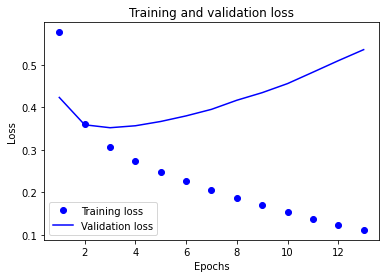

In [33]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

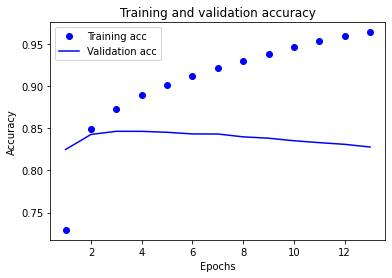

In [34]:
plt.clf() 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
---
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다.

In [35]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 41)


In [56]:
from gensim.models import Word2Vec
import os

# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
word2vec = word_vectors.wv
vector = word2vec['끝']
vector
# 한국어 Word2Vec 사용
# word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
# word2vec = Word2Vec.load(word2vec_path)

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [57]:
word2vec.similar_by_word('끝')

[('마지막', 0.6325399875640869),
 ('결판', 0.5526015758514404),
 ('발목', 0.5465342402458191),
 ('산산조각', 0.5418900847434998),
 ('막바지', 0.5412753820419312),
 ('싫증', 0.5256820917129517),
 ('양쪽', 0.5253474116325378),
 ('무릎', 0.5246764421463013),
 ('후', 0.5051813721656799),
 ('이어진', 0.5038793087005615)]

In [59]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100 # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [60]:
embedding_matrix.shape

(10000, 100)

In [62]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(512))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1255424   
_________________________________________________________________
dense_6 (Dense)              (None, 16)                8208      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 2,263,649
Trainable params: 2,263,649
Non-trainable params: 0
_________________________________________________________________


In [63]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [64]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=256,callbacks=[es],
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
457/457 [==============================] - 17s 33ms/step - loss: 0.4618 - accuracy: 0.7745 - val_loss: 0.3987 - val_accuracy: 0.8161
Epoch 2/20
457/457 [==============================] - 15s 33ms/step - loss: 0.3340 - accuracy: 0.8532 - val_loss: 0.3376 - val_accuracy: 0.8519
Epoch 3/20
457/457 [==============================] - 15s 33ms/step - loss: 0.2795 - accuracy: 0.8815 - val_loss: 0.3314 - val_accuracy: 0.8574
Epoch 4/20
457/457 [==============================] - 15s 33ms/step - loss: 0.2288 - accuracy: 0.9055 - val_loss: 0.3525 - val_accuracy: 0.8563
Epoch 5/20
457/457 [==============================] - 15s 34ms/step - loss: 0.1773 - accuracy: 0.9287 - val_loss: 0.3761 - val_accuracy: 0.8522
Epoch 6/20
457/457 [==============================] - 15s 33ms/step - loss: 0.1250 - accuracy: 0.9504 - val_loss: 0.4439 - val_accuracy: 0.8525
Epoch 7/20
457/457 [==============================] - 15s 33ms/step - loss: 0.0851 - accuracy: 0.9669 - val_loss: 0.5835 - val_accuracy:

In [65]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.8834 - accuracy: 0.8465
[0.8833787441253662, 0.8464511632919312]


In [66]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


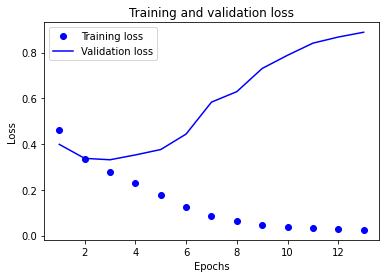

In [67]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

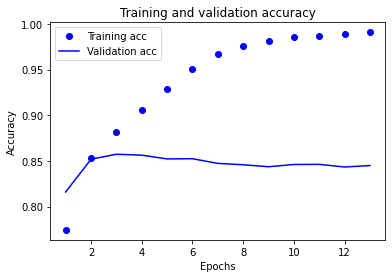

In [68]:
plt.clf()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

전체적으로 85% 내외의 정확성을 보인다. Epochs 2에서 validation loss의 그래프가 train loss와의 이격이 발생한다.
loss가 증가하는 원인을 발견해 좀 더 정확도를 올려야 함